# Selecting the best prompts after convergence

In [1]:
import util

initial_prompts = util.load_initial_prompts(
    "experiment_results/distinct_medical_concepts.txt")
pq = util.PriorityQueue(max_capacity=1000, filter_threshold=0.6, initial=initial_prompts)



c:\Users\kaush\pyenv\ml_env\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\kaush\pyenv\ml_env\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\kaush\pyenv\ml_env\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
from typing import List, Optional
import numpy as np
import matplotlib.pyplot as plt


class KneePointAnalysis:
    """
    A utility class to perform knee-point (elbow) analysis on a collection of scores,
    typically obtained from a PriorityQueue.
    """
    def __init__(self, scores: List[float]):
        """
        Initializes the analyzer with a list of scores.
        Scores are expected to be in descending order for knee-point analysis.
        Ensures scores are numeric by casting to float.
        """
        # Ensure all scores are floats before sorting and storing
        self._scores = sorted([float(s) for s in scores], reverse=True) 

    def find_knee_point(self, k_range: Optional[List[int]] = None, plot: bool = False) -> int:
        """
        Finds the knee point (elbow) in the sorted scores using the 'distance from line' method.
        This suggests a natural 'n' for selecting the best solutions.

        Args:
            k_range: An optional list of K values (number of solutions/ranks) to consider for analysis.
                     If None, it considers all possible 'n' up to the number of scores.
            plot: If True, plots the score curve and the identified knee point.

        Returns:
            The recommended number of 'n' (solutions) based on the knee point.
            Returns 0 if there are no scores or only one score.
        """
        if len(self._scores) <= 1:
            if plot:
                print("Not enough data to plot a knee point (<= 1 score).")
            return len(self._scores)

        # Prepare x-values (ranks) and y-values (scores) for the full dataset
        x_values_all = np.arange(1, len(self._scores) + 1)
        y_values_all = np.array(self._scores) # This conversion now should be safe as _scores are floats

        # Determine the subset of data for analysis if k_range is provided
        if k_range is None:
            x_values_for_analysis = x_values_all
            y_values_for_analysis = y_values_all
        else:
            # Filter x_values and y_values based on k_range
            valid_indices = [i for i, k in enumerate(x_values_all) if k in k_range and k <= len(self._scores)]
            if not valid_indices:
                print("Warning: No valid ranks in k_range for the current data size. Returning 0.")
                return 0
            x_values_for_analysis = x_values_all[valid_indices]
            y_values_for_analysis = y_values_all[valid_indices]

        # Handle cases with insufficient points for line drawing
        if len(x_values_for_analysis) < 2:
            if plot:
                print(f"Not enough points ({len(x_values_for_analysis)}) to confidently determine a knee point for analysis.")
            return len(x_values_for_analysis) if len(x_values_for_analysis) > 0 else 0
        
        # If the analysis range is just two points, the knee is trivially the first point,
        # or the second if the first is disproportionately high. For robustness, if only 2 points,
        # the 'knee' concept is weak.
        if len(x_values_for_analysis) == 2:
             if plot:
                print("Only two points for analysis. Returning the first as default knee candidate.")
             return x_values_for_analysis[0]

        # Calculate the line between the first and last point of the *analysis subset*
        p1 = (x_values_for_analysis[0], y_values_for_analysis[0])
        p2 = (x_values_for_analysis[-1], y_values_for_analysis[-1])

        # Calculate line equation: y = mx + c  =>  mx - y + c = 0
        # Handle the edge case where x_values_for_analysis are all the same (vertical line)
        if (p2[0] - p1[0]) == 0:
            if plot:
                print("Warning: Analysis points fall on a vertical line. Cannot determine knee point effectively.")
            return x_values_for_analysis[0] # Fallback to first point

        m = (p2[1] - p1[1]) / (p2[0] - p1[0])
        c = p1[1] - m * p1[0]

        A, B, C = m, -1, c # Coefficients for Ax + By + C = 0

        distances = []
        for i in range(len(x_values_for_analysis)):
            x0, y0 = x_values_for_analysis[i], y_values_for_analysis[i]
            dist = np.abs(A * x0 + B * y0 + C) / np.sqrt(A**2 + B**2)
            distances.append(dist)

        # The knee point is where the distance is maximized
        knee_index = np.argmax(distances)
        recommended_n = x_values_for_analysis[knee_index] # The rank itself

        if plot:
            plt.figure(figsize=(10, 6))
            # Plot all scores as the primary curve
            plt.plot(x_values_all, y_values_all, marker='o', linestyle='-', color='skyblue', label='All Scores')
            
            # If a k_range was used for analysis, highlight that segment
            if k_range is not None:
                plt.plot(x_values_for_analysis, y_values_for_analysis, marker='x', linestyle='--', color='blue', label='Scores in Analysis Range', markersize=6)
            
            # Plot the baseline line for the analysis subset
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], linestyle='--', color='gray', label='Baseline for Knee Analysis')
            
            # Plot and annotate the identified knee point
            plt.plot(x_values_for_analysis[knee_index], y_values_for_analysis[knee_index], 'ro', markersize=8, label=f'Knee Point (n={recommended_n})')
            plt.annotate(f'n={recommended_n}',
                         xy=(x_values_for_analysis[knee_index], y_values_for_analysis[knee_index]),
                         xytext=(x_values_for_analysis[knee_index] + 0.5, y_values_for_analysis[knee_index] + 0.01),
                         arrowprops=dict(facecolor='black', shrink=0.05),
                         fontsize=10)

            plt.title('Knee Point (Elbow) Analysis of Solution Scores')
            plt.xlabel('Number of Solutions (Rank)')
            plt.ylabel('Score')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend()
            plt.show()

        return recommended_n

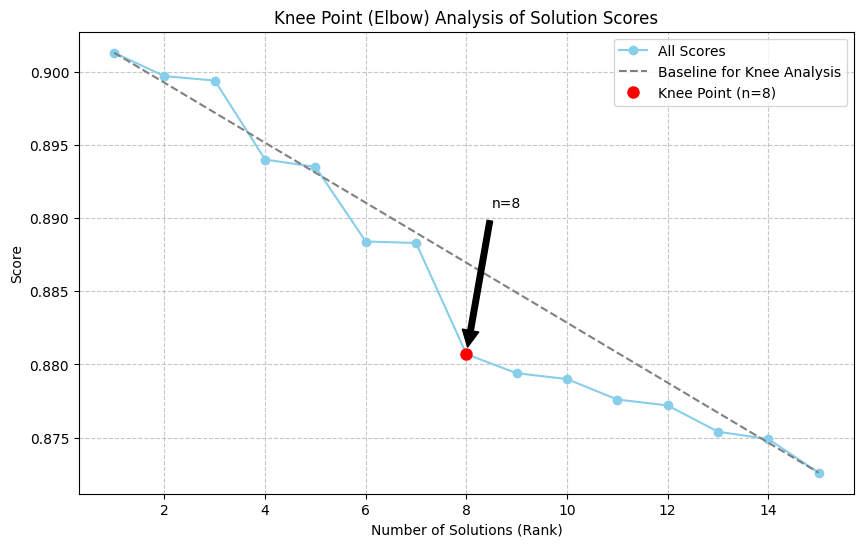


Recommended 'n' based on knee point analysis: 8

Top 8 solutions based on knee point (raw scores):
  1. ('No atypical cells infiltrating surrounding tissues', 'Atypical cells infiltrating surrounding tissues and disrupting normal structures') - Score: 0.9013
  2. ('No significant atypia in the surrounding lymphocytes', 'Significant atypia observed in lymphocytes adjacent to tumor nests') - Score: 0.8997
  3. ('No evidence of fibrosis', 'Prominent stromal fibrosis surrounding tumor nests') - Score: 0.8994
  4. ('Normal follicular architecture is preserved', 'Disrupted follicular architecture with loss of polarity') - Score: 0.8940
  5. ('No prominent nucleoli are observed in lymphocytes', 'Cells exhibit large, prominent, and irregular nucleoli') - Score: 0.8935
  6. ('No giant cells or multinucleated cells are seen', 'Presence of multinucleated giant cells, suggestive of specific tumor types') - Score: 0.8884
  7. ('No plasmacytoid differentiation is observed', 'Plasmacytoid differenti

In [3]:
# 2. Get all sorted scores from the PriorityQueue for analysis
all_current_scores = [score for _, score in pq.get_best_n(len(pq))] # Get all, sorted by score


# 3. Create an instance of KneePointAnalysis with the scores
knee_analyzer = KneePointAnalysis(all_current_scores)

# 4. Find the knee point and plot it
recommended_n_from_knee = knee_analyzer.find_knee_point(plot=True)
print(f"\nRecommended 'n' based on knee point analysis: {recommended_n_from_knee}")

# 5. Get the best 'n' solutions from the PriorityQueue based on the recommended 'n'
if recommended_n_from_knee > 0:
    best_n_solutions = pq.get_best_n(recommended_n_from_knee)
    print(f"\nTop {len(best_n_solutions)} solutions based on knee point (raw scores):")
    for i, (pair, score) in enumerate(best_n_solutions):
        print(f"  {i+1}. {pair} - Score: {score:.4f}")

else:
    print("\nNo best solutions to retrieve based on knee point analysis.")